In [12]:
# import os

# os.environ["OPENAI_API_KEY"] = ""

In [ ]:
# !pip install openai==0.27.8
# !pip install langchain==0.0.212
# !pip install chromadb==0.3.26
# !pip install jupyterlab
# !pip install pandas
# !pip install numpy
# !pip install tiktoken==0.4.0
# !pip install evaluate==0.4.0
# !pip install nltk==3.8.1

# Question Answering with LLMs

## Agenda

- Description
- SQuAD
- Using LLM for Q&A
- Adding context
- Conclusion

# Description

In this notebook we are going to explore Qustion Answering using ChatGPT. 
We will consider two ways:

1. Q&A without context

2. Contextual retrieval Q&A

Question answering in this context refers to question answering over your document data. We are going to predict answers for the questions in SQuAD dataset using LLM.

Stanford Question Answering Dataset [(SQuAD)](https://huggingface.co/datasets/squad) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

We will use "text-davinci-003" model from OpenAI. It is large language model from GPT-3.5 family. They can understand and generate natural language or code. "text-davinci-003" can do any language task with better quality, longer output, and consistent instruction-following than the curie, babbage, or ada models.

An embedding is a vector (list) of floating point numbers. The distance between two vectors measures their relatedness. Small distances suggest high relatedness and large distances suggest low relatedness. We will use OpenAI Embeddings API for our task.

For convinient usage of embeddings with dataset we are going to use vector database.

A vector database is a kind of database specifically designed to handle vector data. Vector data is a type of data that can be represented by a set of numerical values in a multidimensional space. In the context of machine learning and AI, vector data often refers to embeddings, which are high-dimensional vectors that encode information about data points.

As you can notice, Q&A task incudes few components (data, llm, embeddings) that needs to be used together for getting ready to use solution.

[LangChain](https://js.langchain.com/docs/) provide very convinient framework to combine these components together.

LangChain is a framework for developing applications powered by language models. It enables applications that are:

- Data-aware: connect a language model to other sources of data
- Agentic: allow a language model to interact with its environment

The main value props of LangChain are:

- Components: abstractions for working with language models, along with a collection of implementations for each abstraction. Components are modular and easy-to-use, whether you are using the rest of the LangChain framework or not
- Off-the-shelf chains: a structured assembly of components for accomplishing specific higher-level tasks

## 1. SQuAD dataset loading

In [ ]:
!curl -o data/raw_train.json -X GET \
    "https://datasets-server.huggingface.co/rows?dataset=squad&config=plain_text&split=train&offset=0&limit=100"

Lets convert json data to csv format for more convinient usage

In [2]:
import json
import pandas as pd


def convert_squad_to_csv(json_file, csv_file):
    """Convert raw SQuAD json data to csv format"""

    with open(json_file, 'r') as f:
        squad_dict = json.load(f)

    id_list = []
    context_list = []
    question_list = []
    answer_list = []

    for row in squad_dict['rows']:
        data = row['row']
        id_list.append(data['id'])
        context_list.append(data['context'])
        question_list.append(data['question'])
        answer_list.append(data['answers']['text'][0])

    df = pd.DataFrame(zip(id_list, question_list, context_list, answer_list), 
                      columns=['id', 'question', 'context', 'answer'])
    df.to_csv(csv_file, index=False)


In [3]:
convert_squad_to_csv('data/raw_train.json', 'data/train.csv')

### 1.1. EDA

Lets see how is our data distribute, we are most interested in columns 'question' and 'context'. We want to know the "size" of our data in order to be able to estimate costs for API usage

In [4]:
train_df = pd.read_csv('data/train.csv')
print(len(train_df))
train_df.head()

100


,id,question,context,answer
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",Saint Bernadette Soubirous
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",a copper statue of Christ
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",the Main Building
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",a Marian place of prayer and reflection
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",a golden statue of the Virgin Mary


<AxesSubplot: >

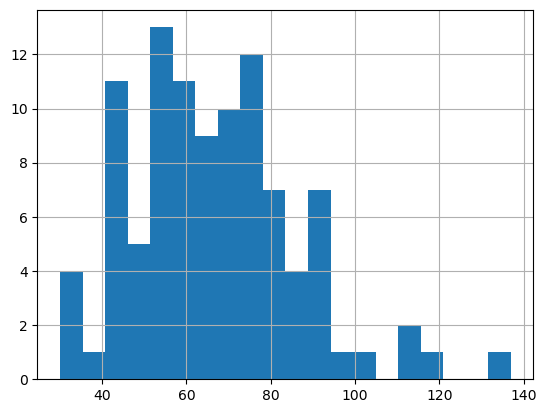

In [182]:
train_df['question'].map(len).hist(bins=20)

<AxesSubplot: >

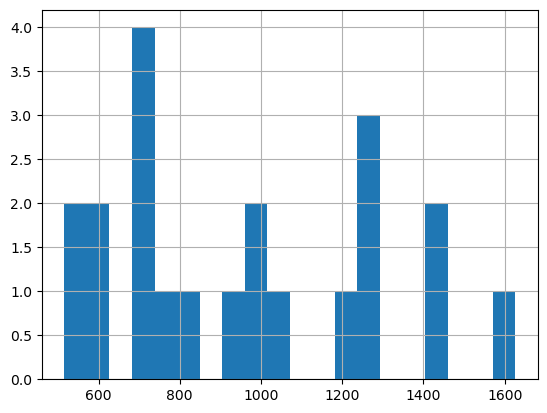

In [183]:
train_df['context'].drop_duplicates().map(len).hist(bins=20)

## 2. Perform Q&A with LLM

In [5]:
from langchain import FewShotPromptTemplate
from langchain import PromptTemplate

### 2.1. Few-shot

Few-shot learning is a machine learning approach where the model learns to make accurate predictions from a very small number of examples, typically in the order of one to five. This technique offers significant benefits such as efficiency in handling sparse data and the ability to generalize well from limited information, making it a versatile choice for tasks where acquiring large labeled datasets is challenging or costly.

In [6]:
def get_examples(df):
    examples = []
    for i, row in df.sample(3).iterrows():
        example = {
            "query": row['question'],
            "answer": row['answer']
        }
        examples.append(example)
    
    return examples

Collect examples from data

In [7]:
examples = get_examples(train_df)
examples

[{'query': 'How many stories tall is the main library at Notre Dame?',
  'answer': '14'},
 {'query': 'Which prize did Frederick Buechner create?',
  'answer': 'Buechner Prize for Preaching'},
 {'query': 'There are how many dorms for females at Notre Dame?',
  'answer': '14'}]

In [8]:
# create a example template
example_template = """
User: {query}
AI: {answer}
"""

# create a prompt example from above template
example_prompt = PromptTemplate(
    input_variables=["query", "answer"],
    template=example_template
)

# now break our previous prompt into a prefix and suffix
# the prefix is our instructions
prefix = """You are a useful assistant with artificial intelligence who gives 
short but accurate answers to the questions asked.
examples: 
"""
# and the suffix our user input and output indicator
suffix = """
User: {query}
AI: """

Build our few-shot prompt

In [9]:
# now create the few shot prompt template
few_shot_prompt_template = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix=suffix,
    input_variables=["query"],
    example_separator="\n\n"
)

Prompt example

In [10]:
print(few_shot_prompt_template.format(query="What is the meaning of life?"))

You are a useful assistant with artificial intelligence who gives 
short but accurate answers to the questions asked.
examples: 



User: How many stories tall is the main library at Notre Dame?
AI: 14



User: Which prize did Frederick Buechner create?
AI: Buechner Prize for Preaching



User: There are how many dorms for females at Notre Dame?
AI: 14



User: What is the meaning of life?
AI: 


Lets evaluate our model on 30 examples:

In [13]:
samples = train_df.sample(30)

### 2.2 Use LLM to predict answers

In [14]:
from langchain.llms import OpenAI


# initialize the models
llm = OpenAI(
    model_name="text-davinci-003"
)

We use [LLMchain](https://js.langchain.com/docs/modules/chains/llm_chain) to wrap our prompt template with a llm. An LLMChain is a simple chain that adds some functionality around language models, in our case we put llm and prompt template together.

In [16]:
from langchain.chains import LLMChain


chain = LLMChain(llm=llm, prompt=few_shot_prompt_template)

Predict answer for each question, we will keep answers from our llm in "llm_answers" column

In [ ]:
samples['llm_answers'] = samples['question'].map(llm.run)

In [ ]:
samples.to_csv('data/sample_answers.csv', index=False)

Lets see at sample of results

In [ ]:
samples.sample(5)

,id,question,context,answer,llm_answers
71,5733b5344776f419006610e0,In what year did Notre Dame begin to host the ...,As of 2012[update] research continued in many ...,2013,2016
62,5733b2fe4776f41900661093,The Lobund Institute was merged into the Depar...,The Lobund Institute grew out of pioneering re...,1958,1966
20,5733a70c4776f41900660f64,What entity provides help with the management ...,All of Notre Dame's undergraduate students are...,Learning Resource Center,The First Year of Studies Office.
17,5733a6424776f41900660f4f,Before the creation of the College of Engineer...,The College of Engineering was established in ...,the College of Science,College of Science
10,5733bed24776f41900661188,Where is the headquarters of the Congregation ...,The university is the major seat of the Congre...,Rome,"Rome, Italy"


As we can see, the model can stick to the correct format, but the facts can be distorted

### 2.3. Evaluating LLM

As per we have ground truths, we can measure the LLM quality on our dataset

We will use squad and ROUGE metric to evaluate Q&A score.

[squad score](https://huggingface.co/spaces/evaluate-metric/squad_v2) - wraps the official scoring script for evaluating in SQuAD chellenge.

`exact`: Exact match (the normalized answer exactly match the gold answer) (see the exact_match metric (forthcoming))\
`f1`: The average F1-score of predicted tokens versus the gold answer (see the F1 score metric)\
`total`: Number of scores considered'\
`HasAns_exact`: Exact match (the normalized answer exactly match the gold answer)\
`HasAns_f1`: The F-score of predicted tokens versus the gold answer\
`HasAns_total`: How many of the questions have answers\
`NoAns_exact`: Exact match (the normalized answer exactly match the gold answer)\
`NoAns_f1`: The F-score of predicted tokens versus the gold answer\
`NoAns_total`: How many of the questions have no answers\
`best_exact` : Best exact match (with varying threshold)\
`best_exact_thresh`: No-answer probability threshold associated to the best exact match\
`best_f1`: Best F1 score (with varying threshold)\
`best_f1_thresh`: No-answer probability threshold associated to the best F1

[ROUGE](https://en.wikipedia.org/wiki/ROUGE_(metric)), or Recall-Oriented Understudy for Gisting Evaluation, is a set of metrics used for evaluating automatic summarization and machine translation. ROUGE includes measures such as:

- ROUGE-N: Overlap of N-grams between the system and reference summaries.
- ROUGE-L: Longest Common Subsequence (LCS) based statistics. Longest common subsequence problem takes into account sentence level structure similarity naturally and identifies longest co-occurring in sequence n-grams automatically.

Question Answering (QA) tasks often require a system to generate precise and concise answers to specific questions. In some QA scenarios, especially those involving more complex or open-ended questions, the answers can be quite long, and there can be more than one correct answer. In such cases, using a metric like Exact Match (EM), which requires the system's output to match the reference answer exactly, might not be appropriate.

ROUGE metrics, initially developed for evaluating automatic summarization tasks, measure the overlap of n-grams between the system output and the reference text. ROUGE can be more flexible and forgiving than EM because it doesn't require the system's output to exactly match the reference. Instead, it measures the extent to which the key pieces of information (as represented by the n-grams) in the reference text also appear in the system's output.

So, if you have a QA task where the answers and reference texts are quite long, and you're more interested in the system's ability to include all the key pieces of information in its answer rather than its ability to exactly reproduce the reference text, then ROUGE could be an appropriate choice of metric.

For instance, ROUGE-1 or ROUGE-2 could be used to measure the overlap of unigrams or bigrams, respectively, which can give a sense of whether the system is including all the key terms or pairs of terms. ROUGE-L, which measures the longest common subsequence, could be used to measure whether the system is maintaining the same general order of information as in the reference text.

In [31]:
import evaluate


rouge = evaluate.load('rouge')
squad_metric = evaluate.load("squad_v2")

In [32]:
def evaluate_llm(samples, pred_col='llm_answers'):
    references = samples['answer'].values
    predictions = samples[pred_col].values

    rouge_res = rouge.compute(predictions=predictions, references=references)

    references, predictions = [], []

    for _, row in samples.iterrows():
        predict = {
            'prediction_text': row[pred_col],
            'id': row['id'],
            'no_answer_probability': 0.
        }
        predictions.append(predict)
        
        reference = {
            'answers': {
                'text': [row['answer']],
                'answer_start': [0]
            },
            'id': row['id']
        }
        references.append(reference)

    res = squad_metric.compute(predictions=predictions, references=references)
    res.update(rouge_res)
    return res

In [ ]:
evaluate_llm(samples)

{'exact': 10.0,
 'f1': 28.064213564213567,
 'total': 30,
 'HasAns_exact': 10.0,
 'HasAns_f1': 28.064213564213567,
 'HasAns_total': 30,
 'best_exact': 10.0,
 'best_exact_thresh': 0.0,
 'best_f1': 28.064213564213567,
 'best_f1_thresh': 0.0,
 'rouge1': 0.2881613756613757,
 'rouge2': 0.11999999999999998,
 'rougeL': 0.2894708994708995,
 'rougeLsum': 0.2831283068783069}

rouge score is not well, lets try to improve it by using context

## 3. Provide context to the model

![Data retrivial](https://python.langchain.com/assets/images/data_connection-c42d68c3d092b85f50d08d4cc171fc25.jpg)
https://python.langchain.com/docs/modules/data_connection/

Despite OpenAI text-davinci-003 was trained on huge amount of data including wikipedia and SQuAd, model can forget some information due to parameters size and data size.

As a llm can continue sequence by given sequence, we can engage context for more robust and accurate performance

For question answering over many documents, you almost always want to create an index over the data. This can be used to smartly access the most relevant documents for a given question, allowing you to avoid having to pass all the documents to the LLM (saving you time and money).

We are going to provide context along the answers to our llm

In [33]:
from langchain.document_loaders import DataFrameLoader

### 3.1 Load data

In [34]:
loader = DataFrameLoader(train_df.drop_duplicates(subset=['context'])[['context']], page_content_column="context")
data = loader.load()

In [35]:
len(data)

21

In [36]:
data[:2]

[Document(page_content='Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', metadata={}),
 Document(page_content="As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several magazines and journals. Begun as a one-page jo

### 3.2 Store context and its embeddings in Chroma vector db

Chroma is the open-source embedding database.

![Croma](https://docs.trychroma.com/img/hrm4.svg)
https://docs.trychroma.com/

Chroma gives you the tools to:

- store embeddings and their metadata
- embed documents and queries
- search embeddings

We will use OpenAI Embeddigs API to get vector representation of our data

In [53]:
from langchain.embeddings import OpenAIEmbeddings


embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')

We store text along with embeddings. Under the hood, we are saying OpenAI API: generate vector representation for each document we provided. After that we put these vectors along with this documents itself.  

Lets create our vector store.

We pass `data` and `embeddings` as an arguments. 

In real-life applications, we want to store our vectors and index in a persistent manner. To achieve this, we are going to pass the `persist_directory` argument, which specifies where to store our data. Then, `db.persist()` will persist the data

In [64]:
from langchain.vectorstores import Chroma


PERSIST_DIRECTORY = 'data/vstore'

db = Chroma.from_documents(data, embeddings, persist_directory=PERSIST_DIRECTORY)
db.persist()

Now we can use index to get context which would be most appropriate in terms of similarity to query we will provide

In [57]:
retriever = db.as_retriever()

Lets show how it looks like

In [42]:
def pretty_print_docs(docs):
    """Helper function for printing docs"""
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))

In [43]:
matches = retriever.vectorstore.search("What is in front of the Notre Dame Main Building?", 'similarity')
pretty_print_docs(matches)

Document 1:

Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
----------------------------------------------------------------------------------------------------
Document 2:

The library system of the university is divided between the main library and each of the colleges and schools. The main building is the 14-story Theodore M. Hesburgh Library, co

We have provided a query and expect to get context which is most similar to our query. How do we decide which context is more similar than another one? That's why we use embeddings. Embeddings can represent our text in a way that keeps similar texts close in vector space and dissimilar ones far away. When we use a retriever, we are comparing the query embedding with each context embedding and picking up the closest one. In cell above we have picked up five most similar context sorted by relevance.

So, if you want to load vector db from disk, you have to use the following code

In [62]:
db = Chroma(persist_directory=PERSIST_DIRECTORY, embedding_function=embeddings)

### 3.3 Retrieving context

![](https://python.langchain.com/assets/images/qa_flow-9fbd91de9282eb806bda1c6db501ecec.jpeg)
https://python.langchain.com/docs/use_cases/question_answering/

Chains in LangChain is just a wappers for common components like llms, prompts, etc. We are going to use built in chain [qa_chain](https://python.langchain.com/docs/modules/chains/additional/question_answering.html) specializing for QA tasks

In [44]:
from langchain.chains.question_answering import load_qa_chain

We create a new prompt, this time taking into account the additional context we retrieve from the corpus

In [45]:
example_template = """
User: {query}
AI: {answer}
"""

example_prompt = PromptTemplate(
    input_variables=["query", "answer"],
    template=example_template
)

prefix = """You are a useful assistant with artificial intelligence who gives 
short but accurate answers to the questions asked using provided context.
examples: 
"""

suffix = """
context: {context}

User: {query}
AI: """

# now create the few shot prompt template
few_shot_prompt_template = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix=suffix,
    input_variables=["context", "query"],
    example_separator="\n\n"
)

For qa chain api we need to explicitly provide query with documents, we can make it by using retrieval

In [46]:
query = 'What is in front of the Notre Dame Main Building?'
docs = retriever.get_relevant_documents(query)

Lets take a look at our chain:

1. We use `chain_type="stuff"` - it means that we take a list of documents, inserts them all into a prompt and passes that prompt to an LLM.
2. `model='text-davinci-003'` - we use Completion API using model OpenAI text-davinci-003
3. `temperature=0` - set temperature parameter for sampling
4. `"input_documents"` - this parameter is in charge of context

In [47]:
chain = load_qa_chain(OpenAI(model='text-davinci-003', temperature=0), chain_type="stuff", prompt=few_shot_prompt_template, verbose=True)
chain({"input_documents": docs, "query": query}, return_only_outputs=True)



> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
You are a useful assistant with artificial intelligence who gives 
short but accurate answers to the questions asked using provided context.
examples: 



User: How many stories tall is the main library at Notre Dame?
AI: 14



User: Which prize did Frederick Buechner create?
AI: Buechner Prize for Preaching



User: There are how many dorms for females at Notre Dame?
AI: 14



context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette

{'output_text': ' A copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".'}

So we can explain what happens under the hood:

1. We take out prompt template with examples how our answer should looks like
2. We select 5 most similar contexts to our query and insert it inside our prompt along with query (final prompt marked as green text)
3. Provide it to the LLM
4. Collect the result

To see prompt and another debug information we use `verbose=True` parameter

### 3.4 Make predictions with context

In [18]:
def make_prediction_with_context(query, retriever=retriever, prompt=few_shot_prompt_template):
    docs = retriever.get_relevant_documents(query)
    
    chain = load_qa_chain(OpenAI(model='text-davinci-003', temperature=0), chain_type="stuff", prompt=prompt)
    out = chain({"input_documents": docs, "query": query}, return_only_outputs=True)
    return out['output_text']

In [ ]:
samples['llm_answers_with_context'] = samples['question'].map(make_prediction_with_context)

In [25]:
samples.to_csv('data/sample_answers_with_context.csv', index=False)

In [52]:
# samples = pd.read_csv('data/sample_answers_with_context.csv')

In [51]:
samples.sample(10)

,id,question,context,answer,llm_answers,llm_answers_with_context
21,5733b2fe4776f41900661092,In what year did Lobund at Notre Dame become a...,The Lobund Institute grew out of pioneering re...,1950,1949,1950
16,5733b2fe4776f41900661093,The Lobund Institute was merged into the Depar...,The Lobund Institute grew out of pioneering re...,1958,1966,1958
26,57338724d058e614000b5c9d,In 1919 a new president of Notre Dame was name...,In 1919 Father James Burns became president of...,Father James Burns,Edward Frederick O'Hara.,Father James Burns
0,5733a7bd4776f41900660f6d,Which department at Notre Dame is the only one...,"The university first offered graduate degrees,...",Department of Pre-Professional Studies,Mendoza College of Business,Pre-Professional Studies
15,5733b0fb4776f41900661042,What professorship did Father Josh Carrier hol...,"Father Joseph Carrier, C.S.C. was Director of ...",Professor of Chemistry and Physics,"Charles E. Sheedy, CSC, Professorship in the ...",Professor of Chemistry and Physics
8,5733a6424776f41900660f51,How many BS level degrees are offered in the C...,The College of Engineering was established in ...,eight,eight,Eight B.S. degrees.
23,57338724d058e614000b5c9e,Over how many years did the change to national...,In 1919 Father James Burns became president of...,three years,10 years,Three years.
29,5733bed24776f41900661188,Where is the headquarters of the Congregation ...,The university is the major seat of the Congre...,Rome,"Rome, Italy","Rome, Italy."
9,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",the Main Building,The Grotto of Our Lady of Lourdes.,The Main Building.
11,5733b5344776f419006610de,The Kellogg Institute for International Studie...,As of 2012[update] research continued in many ...,Notre Dame,University of Notre Dame,University of Notre Dame


Lets measure the score

In [50]:
evaluate_llm(samples, pred_col='llm_answers')

{'exact': 10.0,
 'f1': 28.064213564213567,
 'total': 30,
 'HasAns_exact': 10.0,
 'HasAns_f1': 28.064213564213567,
 'HasAns_total': 30,
 'best_exact': 10.0,
 'best_exact_thresh': 0.0,
 'best_f1': 28.064213564213567,
 'best_f1_thresh': 0.0,
 'rouge1': 0.28449735449735447,
 'rouge2': 0.11888888888888888,
 'rougeL': 0.28488756613756616,
 'rougeLsum': 0.2876917989417989}

In [49]:
evaluate_llm(samples, pred_col='llm_answers_with_context')

{'exact': 66.66666666666667,
 'f1': 77.90196078431373,
 'total': 30,
 'HasAns_exact': 66.66666666666667,
 'HasAns_f1': 77.90196078431373,
 'HasAns_total': 30,
 'best_exact': 66.66666666666667,
 'best_exact_thresh': 0.0,
 'best_f1': 77.90196078431373,
 'best_f1_thresh': 0.0,
 'rouge1': 0.7714995189995191,
 'rouge2': 0.6562962962962964,
 'rougeL': 0.7745815295815295,
 'rougeLsum': 0.7731349206349207}

As we can see, exact, f1 and rouge scores is much better if we provide context to the model!

## 4. Conclusion

Enriching Large Language Models (LLMs) with a context drawn from a document corpus is an effective strategy to tailor the general reasoning and linguistic interactions of LLMs to your specific data. Nonetheless, it's crucial to realize that simple query and retrieval might not yield the optimal results! A thorough understanding of the data is essential to fully leverage the benefits of a retrieval-based question-answering methodology.

## 5. Useful links

- https://python.langchain.com/docs/use_cases/question_answering/semantic-search-over-chat
- https://python.langchain.com/docs/guides/evaluation/question_answering
- https://github.com/openai/openai-cookbook/blob/main/examples/vector_databases/chroma/hyde-with-chroma-and-openai.ipynb
- https://www.youtube.com/watch?v=FQnvfR8Dmr0
- https://platform.openai.com/docs/guides/gpt-best-practices
- https://platform.openai.com/docs/tutorials/web-qa-embeddings

## 6. Bonus: Real project use case

In this section, i want to show how we implemented Question Answering with LLM in an actual customer project. I'll highlight the challenges we encountered and discuss the outcomes we achieved.

### 6.1. Problem description

The client operates an online support platform featuring a vast array of topics, each consisting of a central question and a series of associated discussion messages. This platform, while rich in content, was posing a significant challenge for the client's support team who found themselves dedicating substantial amounts of time to address complex customer inquiries.

To streamline this process and make information retrieval more efficient, we suggested the deployment of a Large Language Model (LLM). The intention was to leverage the LLM's capabilities for contextual search and question answering, enabling a quicker resolution of customer queries. This approach promised not only to optimize the support team's workflow but also to enhance the overall user experience on the platform

Our team encountered several significant challenges during this project. First, we needed to ensure accuracy despite not having access to a historical dataset of user queries. Secondly, the data we were working with was unstructured and included various types of content such as private information, SQL, logs, code snippets, and XML. Further complicating matters, the data set also contained unrelated threads which were not relevant to the clients' issues. These factors combined to make this a complex, multifaceted problem that required a sophisticated solution

### 6.2. Solution

There are main highlight of the solution:

1. 150k messages (HTML)
2. Cleaning data from HTML format, removed sensetive data and unrelated threads
3. Applied context filtration to provide only relevant context to the model or dont provide any
4. Human in the loop evaluation
5. Included references to the original content to enable support team verify the responses
6. Small amount of ground truth from experts (~10 samples)

Below is how solution looks like

![](resources/sol.jpg)

![](resources/obfuscated.jpg)

### 6.3. Result

As a result, we achieved notable time savings for the support team, reducing the time spent on addressing complex customer inquiries. The user experience on the platform was significantly enhanced, and the overall productivity of the support team improved, showcasing the efficacy and practicality of our AI-powered solution.

While the integration of a Large Language Model offers substantial benefits, it's essential to understand that merely deploying the LLM API will not instantly solve all challenges or maximize the value derived from its use. There are several limitations and hurdles to be aware of:

1. **Data Privacy:** Real-world datasets often contain sensitive information that must be carefully handled to maintain privacy standards. Simply feeding all data to the LLM may violate privacy rules, requiring us to develop methods for identifying and removing or anonymizing such sensitive information.

2. **Unstructured Data:** LLMs perform best when the data is well-structured and consistent, which is not always the case with real-world data. Unstructured data, such as free text fields, SQL, logs, code snippets, and XML, require significant pre-processing before they can be effectively utilized by the LLM.

3. **Data Gathering and Preparation:** Collecting and preparing the data for use with the LLM is a non-trivial task that can demand significant time and resources. This includes data cleaning, removal of irrelevant threads, and formatting the data in a way that the LLM can interpret.

4. **Context Relevance:** Not all data in a given dataset may be relevant to the task at hand. Ensuring that the LLM receives only pertinent context to generate accurate and useful responses is an additional challenge that must be addressed.

5. **Evaluation and Verification:** While LLMs can generate responses, verifying the accuracy and appropriateness of these responses is another issue. A human-in-the-loop approach can enhance reliability but also adds another step in the process, which can potentially slow down response times and add to resource demands.

In summary, while LLMs provide a powerful tool for tasks such as question answering and contextual search, their successful implementation requires careful planning, data handling, and an understanding of the inherent limitations.